📂 Cargando archivo: matriz_distancias_tsp.xlsx ...
   Dimensión original: (289, 289)
✅ Matriz maestra normalizada.

 Heurístico NN | Red 100_nodos_v1 | 100 nodos
Ruta: [1, 44, 55, 18, 52, 4, 27, 38, 26, 40, 6, 29, 2, 7, 16, 19, 50, 9, 31, 5, 41, 37, 14, 42, 54, 33, 11, 10, 3, 39, 36, 23, 30, 20, 22, 32, 28, 99, 69, 83, 66, 68, 86, 76, 72, 91, 60, 64, 85, 98, 15, 13, 8, 43, 53, 48, 21, 17, 45, 24, 12, 47, 49, 51, 90, 78, 92, 46, 25, 100, 70, 61, 94, 77, 57, 73, 56, 84, 87, 71, 67, 79, 74, 59, 96, 62, 97, 63, 89, 58, 81, 75, 82, 80, 34, 35, 95, 93, 65, 88, 1]
Costo total: 303.04019162098194
Tiempo de ejecución: 0.0020334720611572266 segundos

 Heurístico NN | Red 100_nodos_v2 | 100 nodos
Ruta: [1, 2, 29, 30, 34, 12, 13, 98, 43, 97, 9, 8, 25, 11, 20, 7, 6, 14, 26, 5, 48, 21, 28, 27, 49, 35, 3, 36, 51, 46, 15, 31, 38, 45, 32, 33, 68, 85, 62, 86, 100, 92, 83, 95, 78, 72, 71, 77, 60, 54, 76, 96, 84, 81, 87, 73, 99, 64, 80, 82, 61, 55, 79, 70, 24, 4, 41, 88, 74, 93, 42, 19, 47, 40, 23, 17, 53

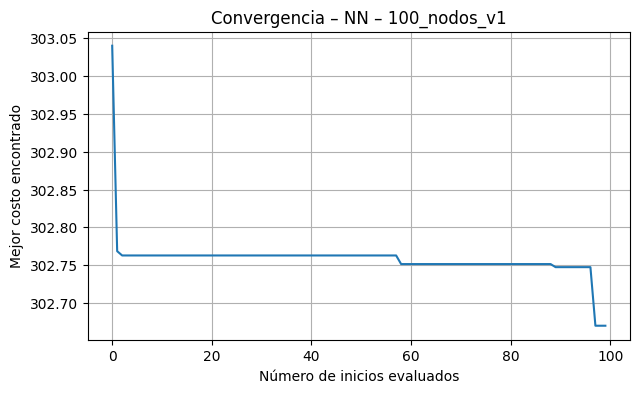

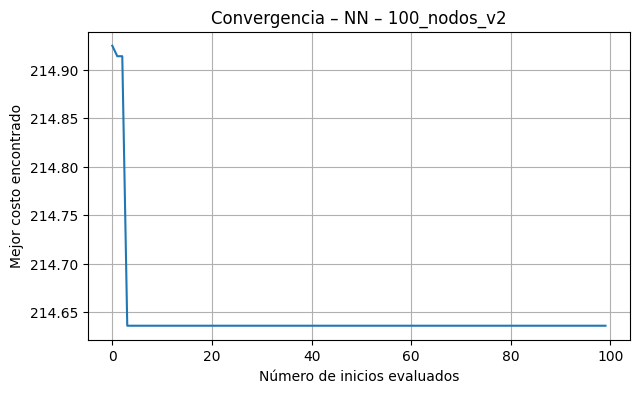

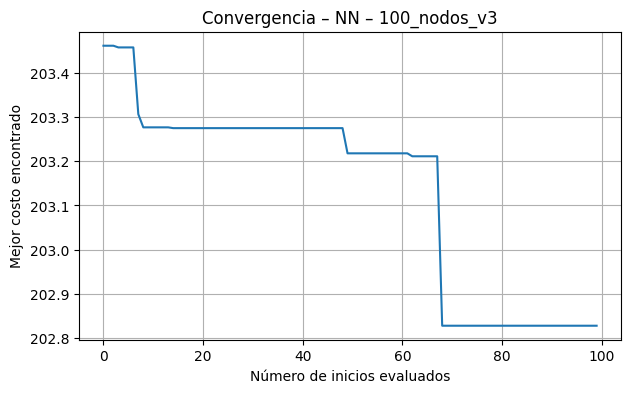

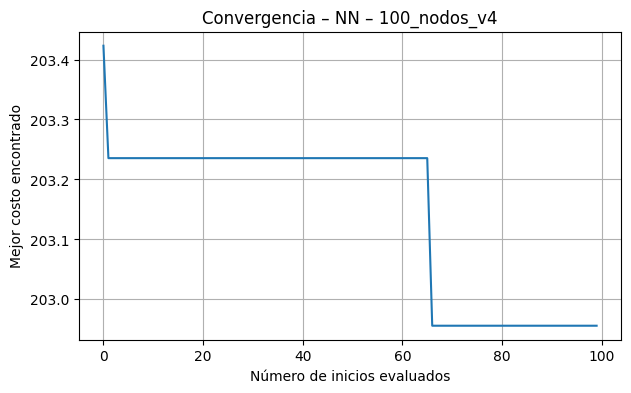

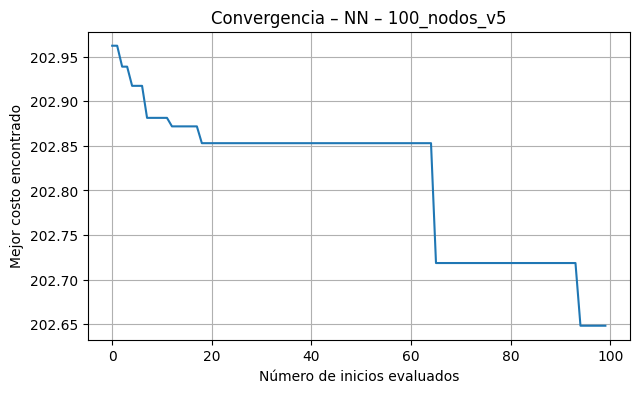

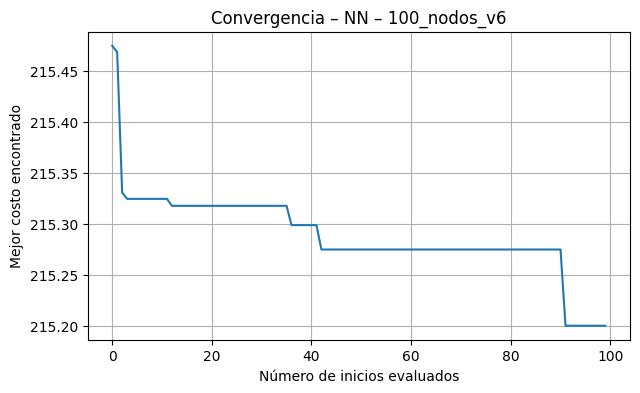

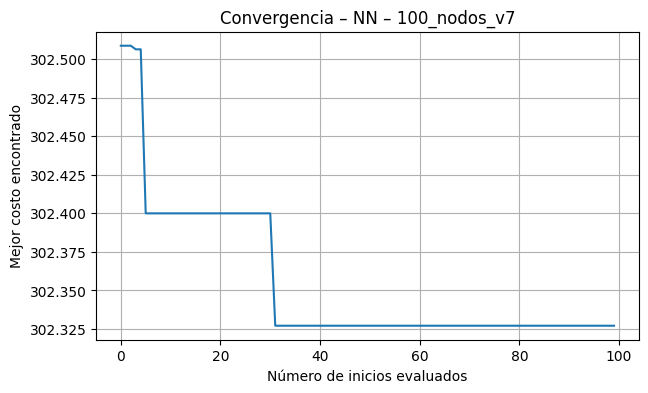

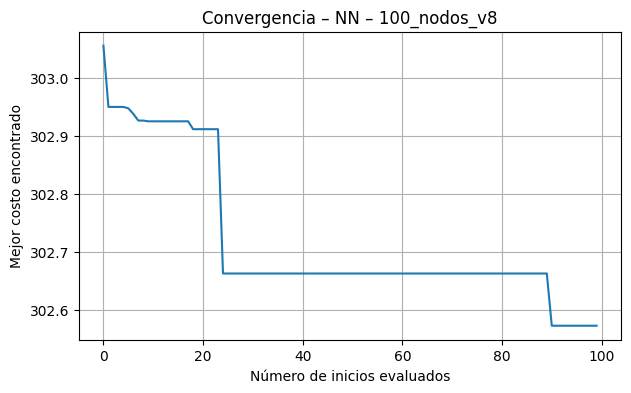

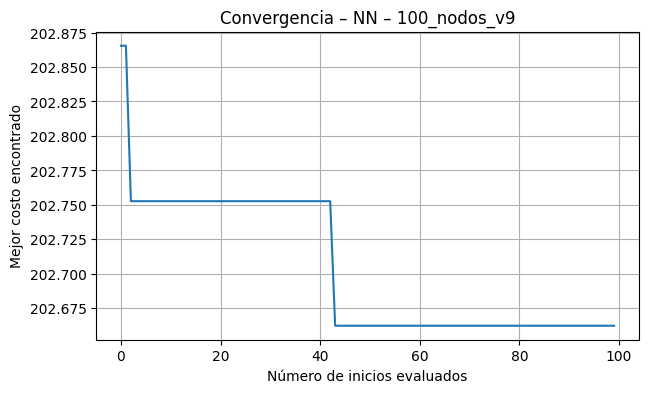

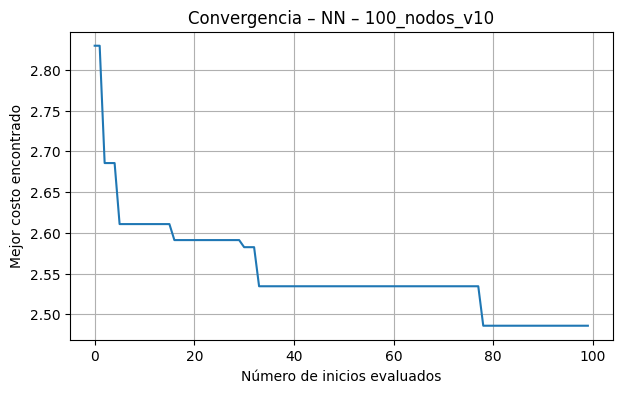

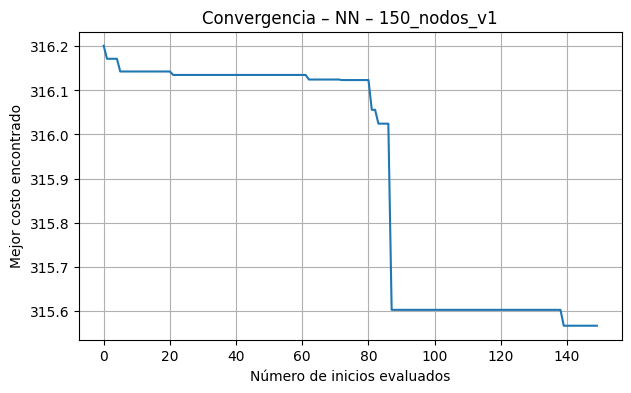

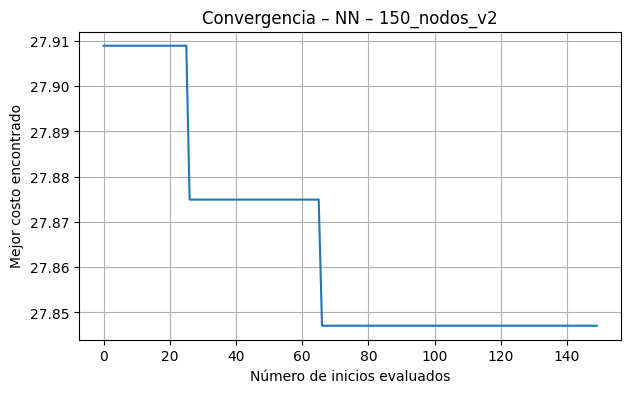

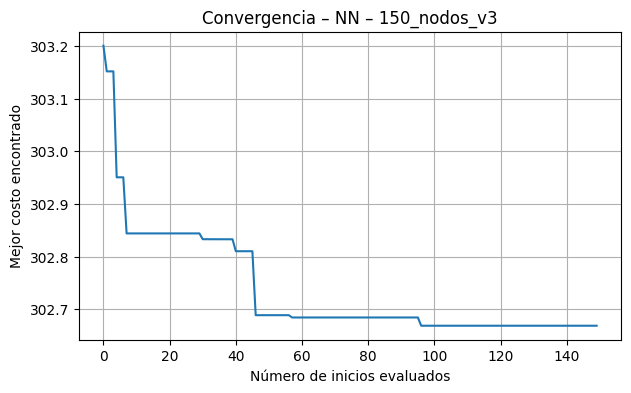

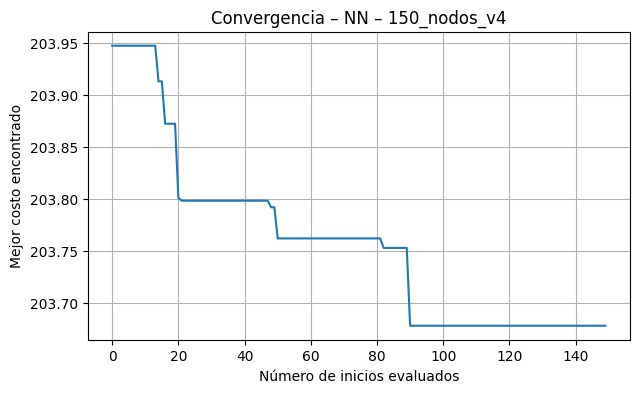

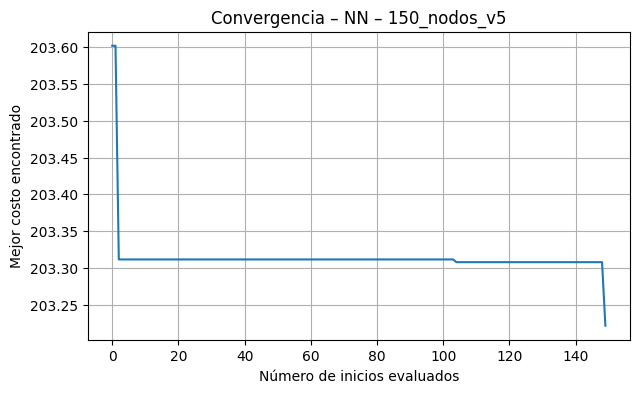

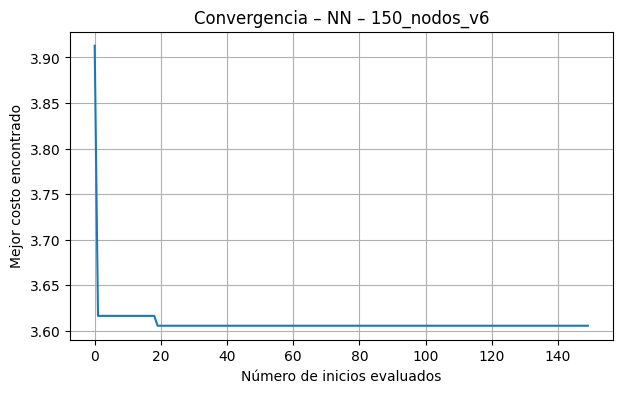

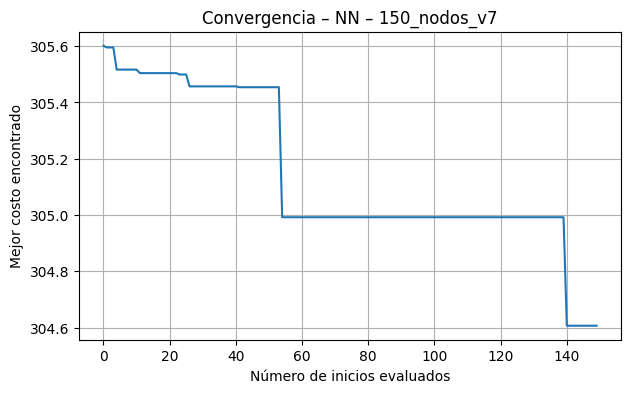

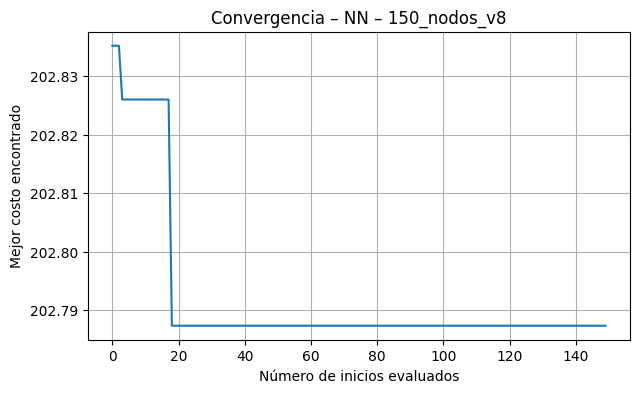

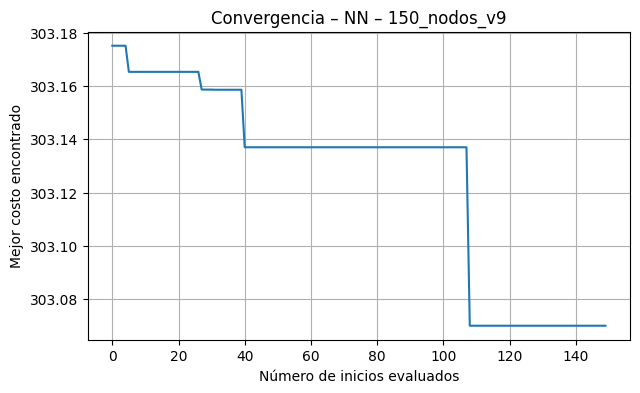

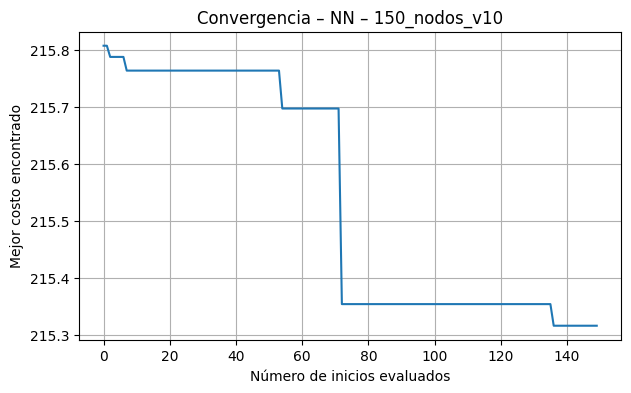

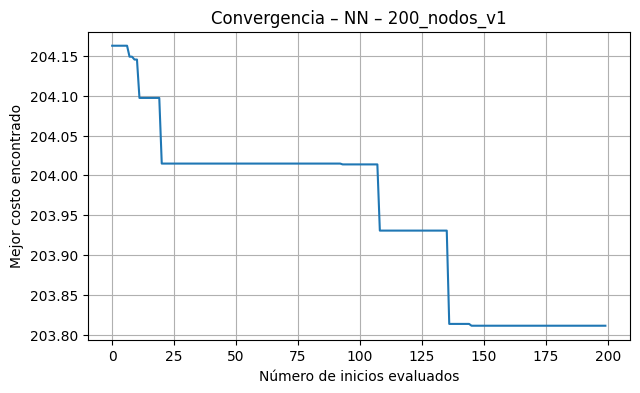

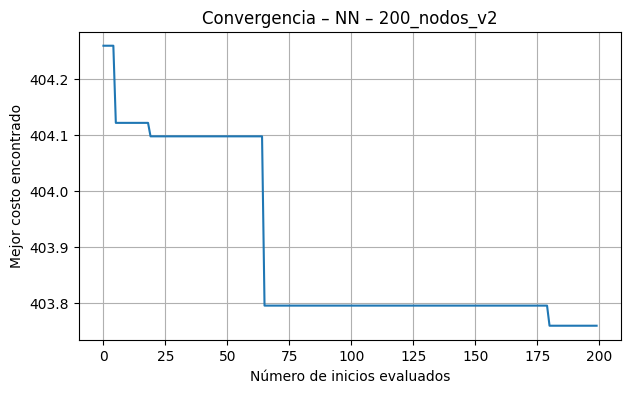

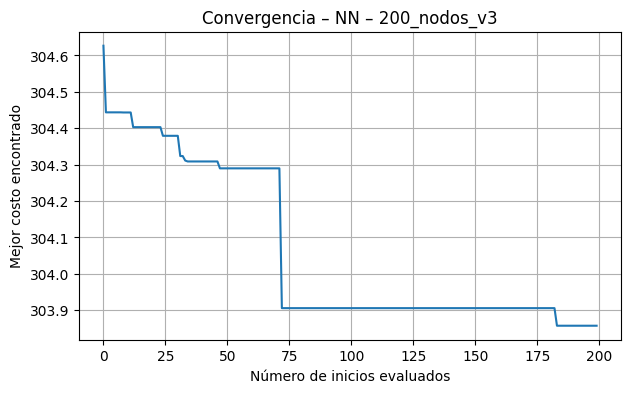

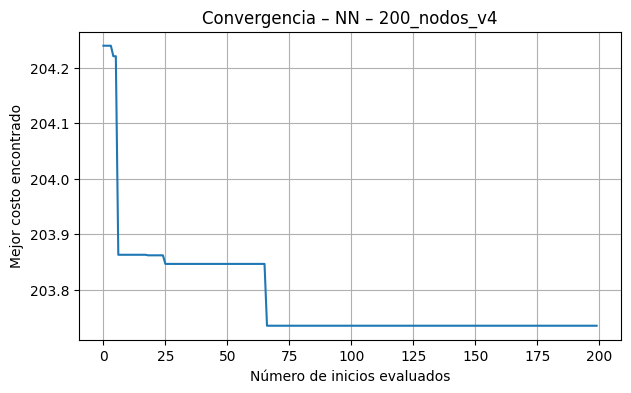

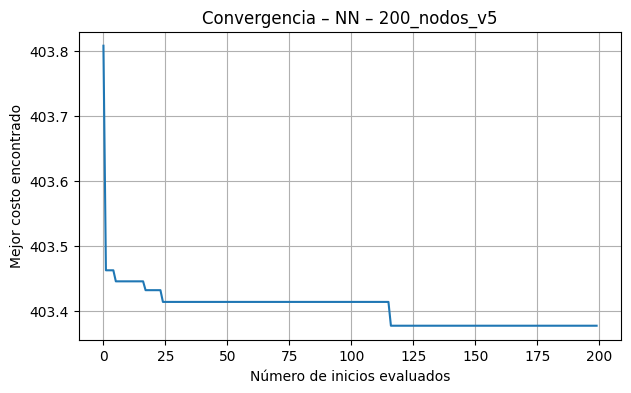

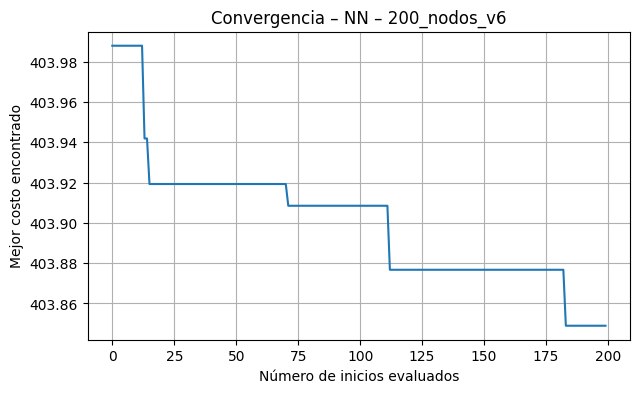

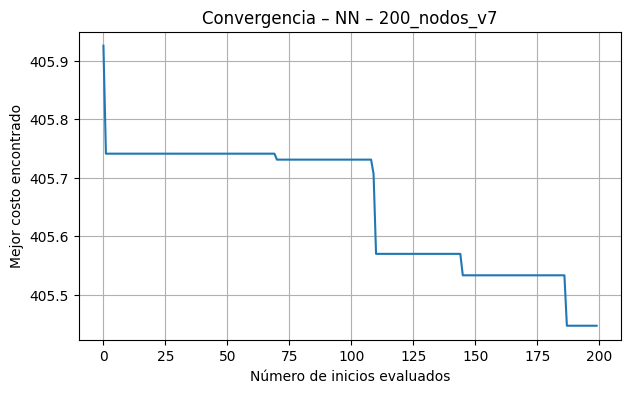

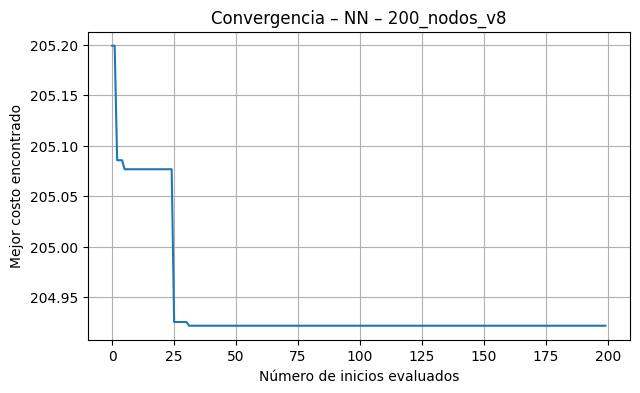

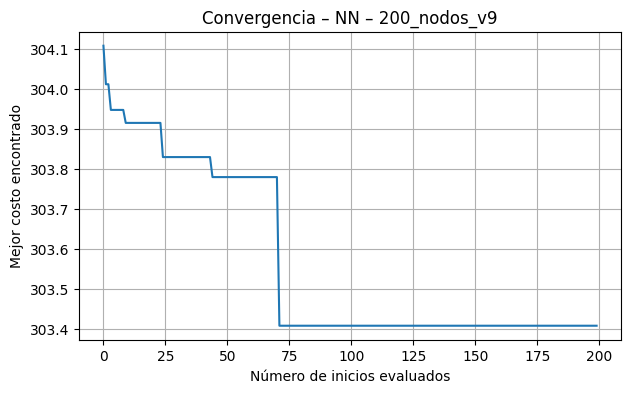

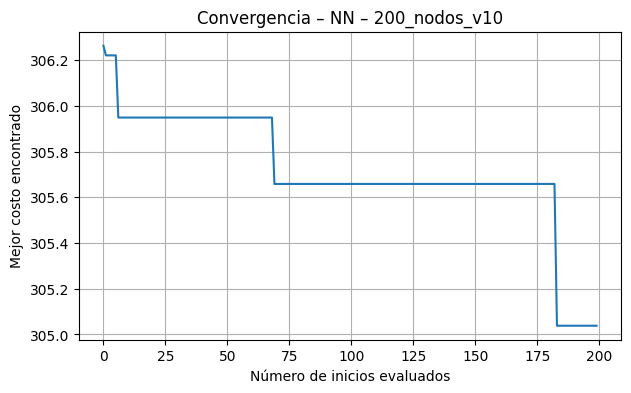


 Promedios por Tamaño de Red (Vecino Más Cercano)
 size  promedio_costo  promedio_tiempo
  100      215.454573         0.002177
  150      208.619210         0.004297
  200      314.657847         0.007756


In [6]:
# =====================================================================
#   LIBRERÍAS
# =====================================================================

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time # Importar la librería time para medir el tiempo de ejecución

# =====================================================================
#   CONFIGURACIÓN GENERAL
# =====================================================================

ARCHIVO_EXCEL = "matriz_distancias_tsp.xlsx"
TAMANOS_REDES = [100, 150, 200]
CANTIDAD_POR_TAMANO = 10
SEED = 42

random.seed(SEED)
np.random.seed(SEED)


# =====================================================================
#   1. CARGAR Y NORMALIZAR MATRIZ DESDE EXCEL
# =====================================================================

def cargar_y_normalizar_matriz(filepath):
    print(f"📂 Cargando archivo: {filepath} ...")

    try:
        df = pd.read_excel(filepath, header=None, index_col=None)
        D = df.values.astype(float)
    except Exception as e:
        print("❌ ERROR AL CARGAR EXCEL →", e)
        return None

    print("   Dimensión original:", D.shape)

    try:
        # 1. Diagonal = 0
        np.fill_diagonal(D, 0)

        # 2. Hacer simétrica
        D = (D + D.T) / 2

        # 3. Reemplazar NaNs
        max_val = np.nanmax(D)
        D = np.nan_to_num(D, nan=max_val)

        # 4. Outliers (percentil 99)
        perc99 = np.percentile(D, 99)
        D[D > perc99] = perc99

        # 5. Normalizar a [0,100]
        if D.max() != 0:
            D = (D / D.max()) * 100

        # 6. Evitar ceros fuera de diagonal
        mask_zero = (D < 0.01) & (np.eye(D.shape[0]) == 0)
        D[mask_zero] = 0.01

        print("✅ Matriz maestra normalizada.")

    except Exception as e:
        print("❌ ERROR DURANTE NORMALIZACIÓN →", e)
        return None

    return D


# =====================================================================
#   2. GENERAR SUBREDES (MISMA FUNCIÓN QUE ACO Y GA)
# =====================================================================

def generar_lotes_redes(matriz_maestra, sizes, n_per_size):
    lote = []
    total_nodos = matriz_maestra.shape[0]

    for s in sizes:
        if s > total_nodos:
            print(f"⚠️ No se puede generar {s} nodos; matriz tiene {total_nodos}.")
            continue

        for i in range(n_per_size):
            indices = sorted(random.sample(range(total_nodos), s))
            submat = matriz_maestra[np.ix_(indices, indices)]

            lote.append({
                "id_interno": f"{s}_nodos_v{i+1}",
                "n_nodos": s,
                "indices_reales": indices,
                "matriz_dist": submat
            })

    return lote


# =====================================================================
#   3. HEURÍSTICO DEL VECINO MÁS CERCANO
# =====================================================================

def tsp_vecino_mas_cercano(dist, ciudad_inicio=0):
    n = len(dist)
    visitado = [False] * n
    ruta = [ciudad_inicio]
    visitado[ciudad_inicio] = True
    actual = ciudad_inicio

    for _ in range(n - 1):
        mejor = None
        mejor_dist = float("inf")

        for j in range(n):
            if not visitado[j] and dist[actual][j] < mejor_dist:
                mejor_dist = dist[actual][j]
                mejor = j

        ruta.append(mejor)
        visitado[mejor] = True
        actual = mejor

    ruta.append(ciudad_inicio)

    costo = sum(dist[ruta[i]][ruta[i+1]] for i in range(len(ruta)-1))
    return ruta, costo


# =====================================================================
#   4. APLICAR HEURÍSTICO A TODAS LAS SUBREDES
# =====================================================================

def resolver_vecino_mas_cercano_en_lote(redes, ciudad_inicio=0):
    resultados = []

    for r in redes:
        dist = r["matriz_dist"]
        size = r["n_nodos"]
        rid = r["id_interno"]

        start_time = time.time()
        ruta, costo = tsp_vecino_mas_cercano(dist, ciudad_inicio)
        end_time = time.time()
        tiempo_ejecucion = end_time - start_time

        ruta_nodos = [i + 1 for i in ruta]

        print("\n======================================")
        print(f" Heurístico NN | Red {rid} | {size} nodos")
        print("======================================")
        print("Ruta:", ruta_nodos)
        print("Costo total:", costo)
        print("Tiempo de ejecución:", tiempo_ejecucion, "segundos")

        resultados.append({
            "id": rid,
            "size": size,
            "ruta_indices": ruta,
            "ruta_nodos": ruta_nodos,
            "costo_total": costo,
            "tiempo_ejecucion": tiempo_ejecucion
        })

    return resultados


# =====================================================================
#   5. CONVERGENCIA DEL HEURÍSTICO (EQUIVALENTE AL GA/ACO)
# =====================================================================

def convergencia_vecino_mas_cercano(dist, modo="todos_los_inicios", num_iteraciones=None):
    n = len(dist)

    if modo == "todos_los_inicios":
        inicios = list(range(n))
    elif modo == "inicios_aleatorios":
        if num_iteraciones is None:
            num_iteraciones = n
        inicios = [random.randrange(n) for _ in range(num_iteraciones)]
    else:
        raise ValueError("Modo inválido.")

    mejores = []
    mejor_actual = float("inf")

    for inicio in inicios:
        _, costo = tsp_vecino_mas_cercano(dist, inicio)
        mejor_actual = min(mejor_actual, costo)
        mejores.append(mejor_actual)

    return mejores


# =====================================================================
#   6. EJECUCIÓN COMPLETA
# =====================================================================

# 1) Cargar matriz
matriz_maestra = cargar_y_normalizar_matriz(ARCHIVO_EXCEL)

# 2) Generar subredes reales
redes = generar_lotes_redes(
    matriz_maestra,
    TAMANOS_REDES,
    CANTIDAD_POR_TAMANO
)

# 3) Ejecutar heurístico NN en todas las redes
resultados_nn = resolver_vecino_mas_cercano_en_lote(redes, ciudad_inicio=0)


# =====================================================================
#   7. GRAFICAR CONVERGENCIA
# =====================================================================

for r in redes:
    dist = r["matriz_dist"]
    hist = convergencia_vecino_mas_cercano(dist)

    plt.figure(figsize=(7,4))
    plt.plot(hist)
    plt.title(f"Convergencia – NN – {r['id_interno']}")
    plt.xlabel("Número de inicios evaluados")
    plt.ylabel("Mejor costo encontrado")
    plt.grid(True)
    plt.show()


# =====================================================================
#   8. ANÁLISIS DE RESULTADOS POR TAMAÑO DE RED
# =====================================================================

if resultados_nn:
    df_resultados = pd.DataFrame(resultados_nn)

    # Agrupar por tamaño de red y calcular promedios
    promedios_por_tamano = df_resultados.groupby('size').agg(
        promedio_costo=('costo_total', 'mean'),
        promedio_tiempo=('tiempo_ejecucion', 'mean')
    ).reset_index()

    print("\n======================================================")
    print(" Promedios por Tamaño de Red (Vecino Más Cercano)")
    print("======================================================")
    print(promedios_por_tamano.to_string(index=False))
else:
    print("No se generaron resultados para analizar.")



 Heurístico NN | Red 40_nodos_v1 | 40 nodos
Ruta: [1, 7, 13, 11, 3, 15, 5, 14, 10, 9, 25, 23, 12, 8, 2, 32, 21, 37, 31, 29, 36, 24, 28, 18, 17, 26, 19, 30, 33, 22, 27, 35, 38, 40, 20, 39, 34, 16, 4, 6, 1]
Costo total: 1.6751894013926165
Tiempo de ejecución: 0.0008401870727539062 segundos

 Heurístico NN | Red 40_nodos_v2 | 40 nodos
Ruta: [1, 16, 40, 2, 12, 14, 3, 10, 7, 13, 15, 9, 20, 11, 8, 19, 18, 5, 6, 4, 34, 26, 29, 21, 25, 27, 37, 31, 39, 35, 38, 32, 33, 22, 30, 28, 36, 23, 24, 17, 1]
Costo total: 202.3834203941422
Tiempo de ejecución: 0.0010249614715576172 segundos

 Heurístico NN | Red 40_nodos_v3 | 40 nodos
Ruta: [1, 19, 36, 29, 38, 37, 32, 33, 26, 39, 6, 18, 5, 8, 13, 4, 11, 15, 10, 12, 3, 16, 2, 7, 17, 14, 28, 30, 25, 22, 34, 9, 27, 35, 21, 20, 31, 40, 23, 24, 1]
Costo total: 201.31308171879664
Tiempo de ejecución: 0.0014622211456298828 segundos

 Heurístico NN | Red 40_nodos_v4 | 40 nodos
Ruta: [1, 8, 24, 9, 4, 7, 18, 6, 3, 17, 11, 5, 15, 12, 2, 20, 16, 40, 34, 36, 38, 29, 

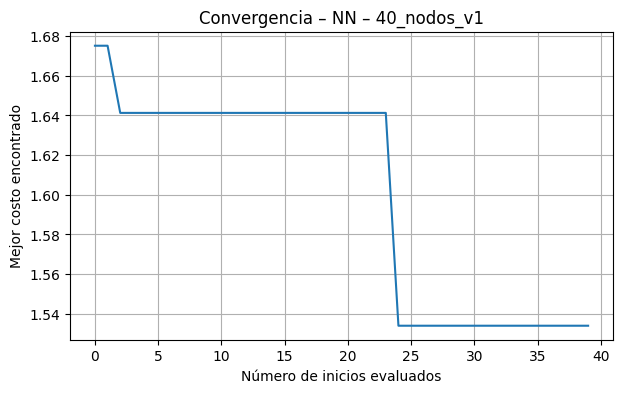

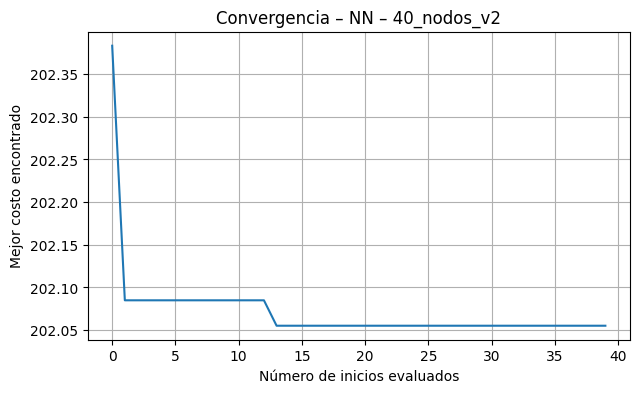

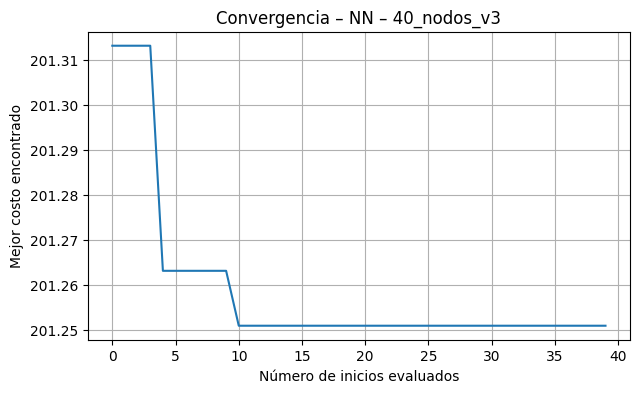

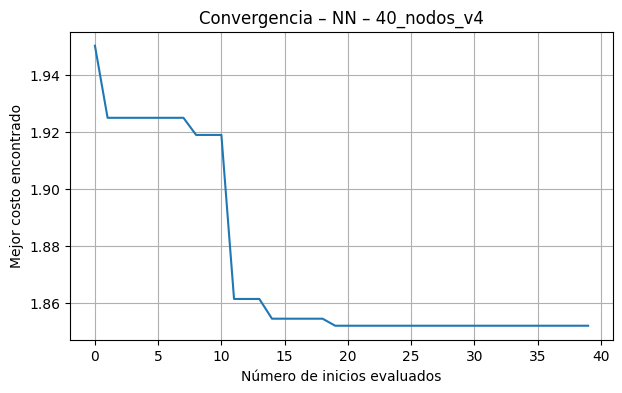

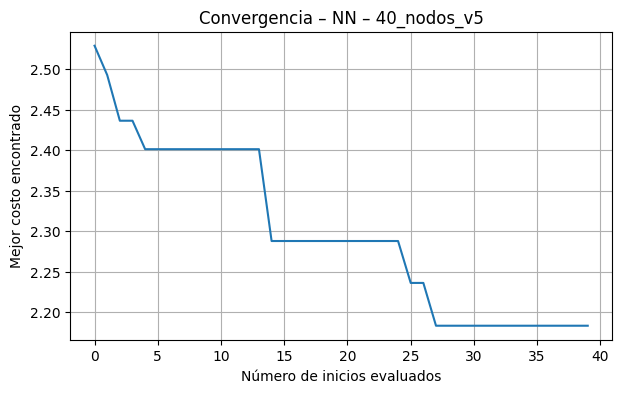

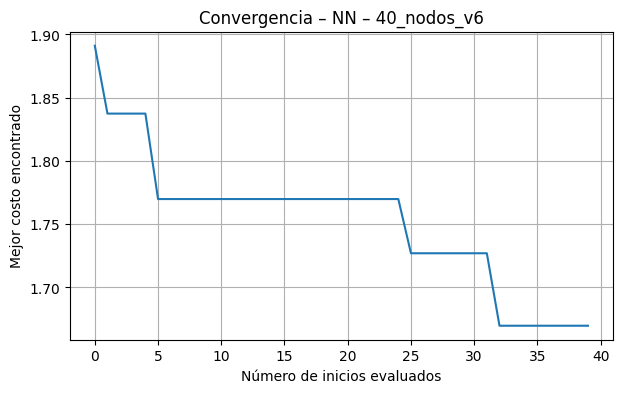

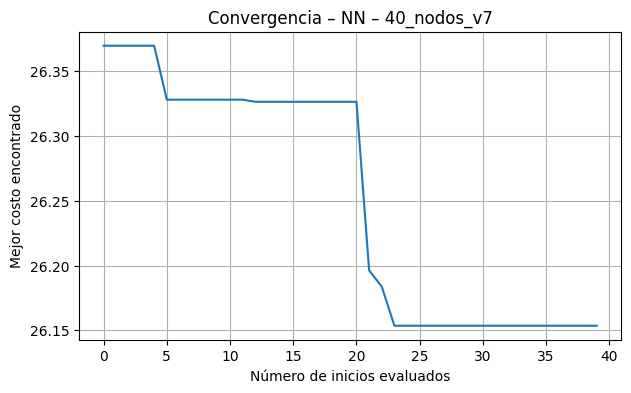

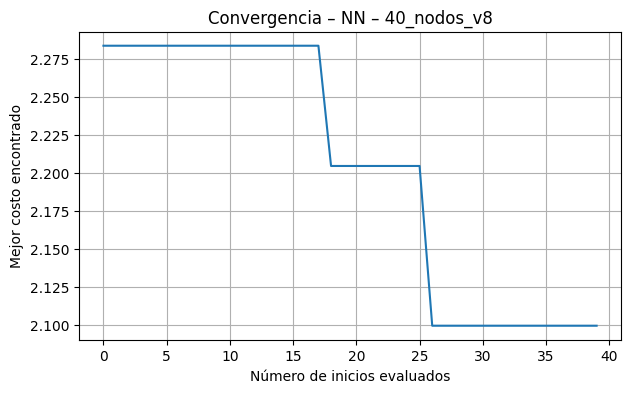

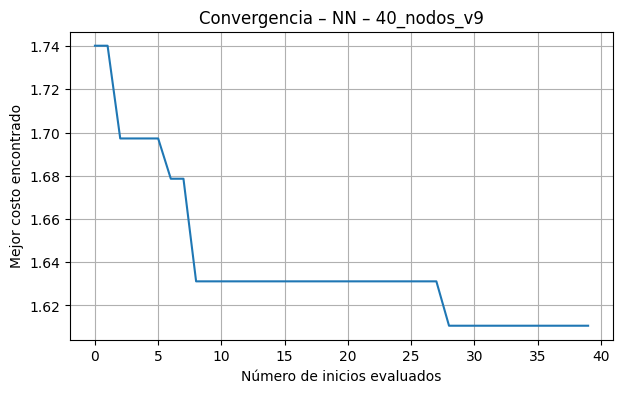

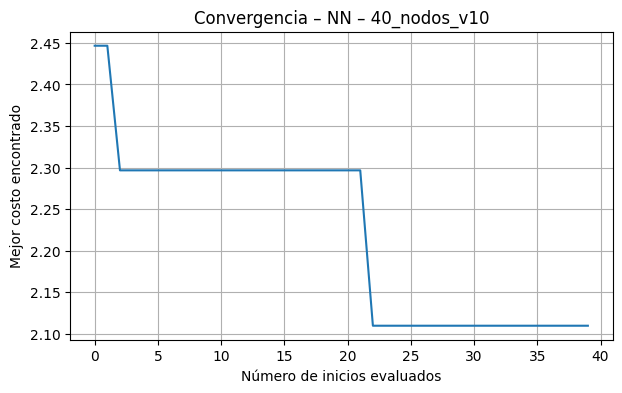


 Promedios por Tamaño de Red (Vecino Más Cercano) - 40 Nodos
 size  promedio_costo  promedio_tiempo
   40       44.458211         0.000689


In [5]:
# =====================================================================
#   EJECUCIÓN PARA 40 NODOS (Copia del código original con modificación de parámetros)
# =====================================================================

# Reutilizar matriz_maestra que ya está cargada y normalizada
# Si matriz_maestra no estuviera en el scope o fuera None, necesitaríamos recargarla.
# En este caso, asumimos que la ejecución anterior fue exitosa y la variable existe.

# Definir el nuevo tamaño de red para esta ejecución
TAMANOS_REDES_40 = [40]

# 1) Generar subredes para 40 nodos
redes_40_nodos = generar_lotes_redes(
    matriz_maestra,
    TAMANOS_REDES_40,
    CANTIDAD_POR_TAMANO
)

# 2) Ejecutar heurístico NN en las redes de 40 nodos
resultados_nn_40 = resolver_vecino_mas_cercano_en_lote(redes_40_nodos, ciudad_inicio=0)

# 3) Graficar convergencia para las redes de 40 nodos
print("\n--- Gráficos de Convergencia para redes de 40 nodos ---")
for r in redes_40_nodos:
    dist = r["matriz_dist"]
    hist = convergencia_vecino_mas_cercano(dist)

    plt.figure(figsize=(7,4))
    plt.plot(hist)
    plt.title(f"Convergencia – NN – {r['id_interno']}")
    plt.xlabel("Número de inicios evaluados")
    plt.ylabel("Mejor costo encontrado")
    plt.grid(True)
    plt.show()

# 4) Análisis de resultados por tamaño de red para 40 nodos
if resultados_nn_40:
    df_resultados_40 = pd.DataFrame(resultados_nn_40)

    # Agrupar por tamaño de red y calcular promedios
    promedios_por_tamano_40 = df_resultados_40.groupby('size').agg(
        promedio_costo=('costo_total', 'mean'),
        promedio_tiempo=('tiempo_ejecucion', 'mean')
    ).reset_index()

    print("\n======================================================")
    print(" Promedios por Tamaño de Red (Vecino Más Cercano) - 40 Nodos")
    print("======================================================")
    print(promedios_por_tamano_40.to_string(index=False))
else:
    print("No se generaron resultados para analizar para 40 nodos.")
